In [1]:
import pandas as pd
import utils
import numpy as np
import plotly.express as px

[TODO]

In this notebook, we calculate the mean average precision for the task of retrieving gene-compound pairs against random pairs. The following are the steps taken
1. Normalized, feature selected ORF, CRISPR and Compound profiles are read and the replicate plates are merged into a single dataframe, for each time point and cell line.
2. All the target annotations of the compounds are used in this analysis.
3. Negcon and empty wells are removed from the dataframe.
4. Average precision (AP) is computed for each chemical perturbation. Mean average precision (mAP) is computed for each perturbation.
5. The AP of a random classifier is subtracted from each perturbation’s AP.
6. Table of AP values is printed and bar plot of AP is plotted.

In [2]:
replicability_df = pd.DataFrame()
biological_consistency_df = pd.DataFrame()

feature_to_group_by = "Metadata_broad_sample"
batch = "2020_11_04_CPJUMP1_DL"

experiment_df = (
    pd.read_csv('output/experiment-metadata.tsv', sep='\t')
    .query('Batch==@batch')
)

target1_metadata = (
    pd.read_csv('input/JUMP-Target-1_compound_metadata_additional_annotations.tsv', sep='\t', usecols=['broad_sample', 'target_list'])
    .rename(columns={'broad_sample':'Metadata_broad_sample', 'target_list':'Metadata_target_list'})
)

In [3]:
for cell in experiment_df.Cell_type.unique():
    cell_df = experiment_df.query('Cell_type==@cell')
    modality_1_perturbation = "compound"
    modality_1_experiments_df = cell_df.query('Perturbation==@modality_1_perturbation')
    for modality_1_timepoint in modality_1_experiments_df.Time.unique():
        modality_1_timepoint_df = modality_1_experiments_df.query('Time==@modality_1_timepoint')
        modality_1_df = pd.DataFrame()
        for plate in modality_1_timepoint_df.Assay_Plate_Barcode.unique():
            # Read all the plates
            data_df = (
                utils.load_data(batch, plate, "spherized.csv.gz")
                .assign(Metadata_modality=modality_1_perturbation)
            )
            modality_1_df = utils.concat_profiles(modality_1_df, data_df)

        # Set Metadata_broad_sample value to "DMSO" for DMSO wells
        modality_1_df[feature_to_group_by].fillna("DMSO", inplace=True)

        # Remove empty wells
        modality_1_df = utils.remove_empty_wells(modality_1_df)

        # time
        time_1 = utils.time_point(modality_1_perturbation, modality_1_timepoint)

        # Calculate replicability mAP
        replicability_precision = utils.PrecisionScores(modality_1_df, modality_1_df, feature_to_group_by, within=True, challenge_negcon=True)

        replicability_df = replicability_df.append({'Description':f'{modality_1_perturbation}_{cell}_{modality_1_timepoint}',
                                                    'Modality':f'{modality_1_perturbation}',
                                                    'Cell':f'{cell}',
                                                    'time':f'{time_1}',
                                                    'mAP':f'{replicability_precision.map:.3f}'}, ignore_index=True)

        # Remove DMSO wells
        modality_1_df = utils.remove_negcon_empty_wells(modality_1_df)

        # Create consensus profiles
        modality_1_consensus_df = utils.consensus(modality_1_df, feature_to_group_by)

        # Filter out non-replicable compounds
        compound_precision_df = replicability_precision.ap_group
        replicable_compounds = list(compound_precision_df.query("ap>0")[feature_to_group_by])
        modality_1_consensus_df = modality_1_consensus_df.query('Metadata_broad_sample==@replicable_compounds').reset_index(drop=True)

        # Adding additional gene annotation metadata
        modality_1_consensus_df = (
            modality_1_consensus_df.merge(target1_metadata, on='Metadata_broad_sample', how='left')
            .assign(Metadata_gene=lambda x: x.Metadata_target_list.str.split('|'))
            .assign(Metadata_gene_list=lambda x: x.Metadata_target_list.str.split('|'))
            .explode('Metadata_gene')
            .reset_index(drop=True)
        )

        all_modality_2_experiments_df = cell_df.query('Perturbation!=@modality_1_perturbation')
        for modality_2_perturbation in all_modality_2_experiments_df.Perturbation.unique():
            modality_2_experiments_df = all_modality_2_experiments_df.query('Perturbation==@modality_2_perturbation')
            for modality_2_timepoint in modality_2_experiments_df.Time.unique():
                modality_2_timepoint_df = modality_2_experiments_df.query('Time==@modality_2_timepoint')
                modality_2_df = pd.DataFrame()
                for plate in modality_2_timepoint_df.Assay_Plate_Barcode.unique():
                    data_df = (
                        utils.load_data(batch, plate, "spherized.csv.gz")
                        .assign(Metadata_modality=modality_2_perturbation)
                        .assign(Metadata_gene_list=lambda x: x.Metadata_gene)
                    )
                    modality_2_df = utils.concat_profiles(modality_2_df, data_df)

                # Remove empty wells
                modality_2_df = utils.remove_empty_wells(modality_2_df)

                # time
                time_2 = utils.time_point(modality_2_perturbation, modality_2_timepoint)

                # Calculate replicability mAP
                replicability_precision = utils.PrecisionScores(modality_2_df, modality_2_df, feature_to_group_by, within=True, challenge_negcon=True)

                replicability_df = replicability_df.append({'Description':f'{modality_2_perturbation}_{cell}_{modality_2_timepoint}',
                                                    'Modality':f'{modality_2_perturbation}',
                                                    'Cell':f'{cell}',
                                                    'time':f'{time_2}',
                                                    'mAP':f'{replicability_precision.map:.3f}'}, ignore_index=True)


                # Remove negcon wells
                modality_2_df = utils.remove_negcon_empty_wells(modality_2_df)

                # Create consensus profiles
                modality_2_consensus_df = utils.consensus(modality_2_df, "Metadata_broad_sample")

                # Filter out non-replicable genes
                precision_df = replicability_precision.ap_group
                replicable_genes = list(precision_df.query("ap>0")[feature_to_group_by])
                modality_2_consensus_df = modality_2_consensus_df.query('Metadata_broad_sample==@replicable_genes').reset_index(drop=True)

                # Filter out compounds without a paired genetic perturbation
                modality_2_genes = list(np.unique(list(modality_2_consensus_df.Metadata_gene)))
                modality_1_consensus_df = modality_1_consensus_df.query('Metadata_gene==@modality_2_genes').reset_index(drop=True)

                # Calculate biological consistency mAP

                retrievability_precision = utils.PrecisionScores(modality_1_consensus_df, modality_2_consensus_df, "Metadata_gene", anti_correlation=True)

                biological_consistency_df = biological_consistency_df.append({'Description':f'{modality_1_perturbation}_{time_1} vs. {modality_2_perturbation}_{time_2}',
                                                                              'Modality1': f'{modality_1_perturbation}_{time_1}',
                                                                              'Modality2': f'{modality_2_perturbation}_{time_2}',
                                                                              'Cell': cell,
                                                                              'mAP':f'{retrievability_precision.map:.3f}'}, ignore_index=True)


In [4]:
# Remove duplicate entries
replicability_df.drop_duplicates(inplace=True)

Replicability mAP

In [5]:
print(replicability_df[['Description', 'time', 'mAP']].to_markdown(index=False))

| Description      | time   |   mAP |
|:-----------------|:-------|------:|
| compound_U2OS_48 | long   | 0.532 |
| crispr_U2OS_144  | long   | 0.32  |
| orf_U2OS_96      | long   | 0.277 |


Biological consistency mAP

In [6]:
print(biological_consistency_df[['Description', 'mAP']].to_markdown(index=False))

| Description                   |   mAP |
|:------------------------------|------:|
| compound_long vs. crispr_long | 0.027 |
| compound_long vs. orf_long    | 0.037 |


In [7]:
replicability_df['mAP'] = replicability_df['mAP'].astype(float)
biological_consistency_df['mAP'] = biological_consistency_df['mAP'].astype(float)

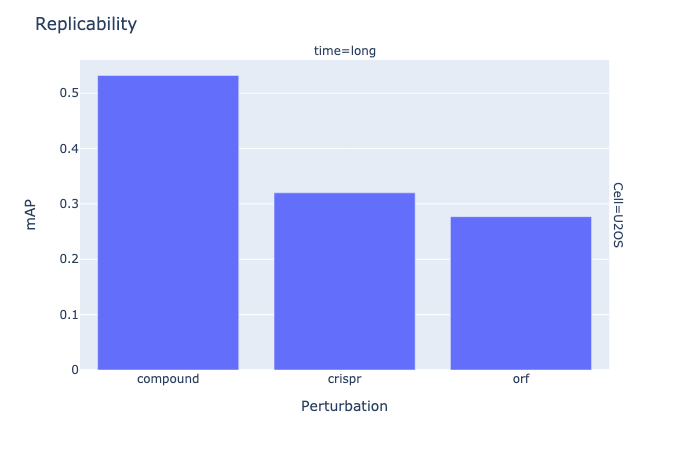

In [8]:
fig = px.bar(data_frame=replicability_df,
             x='Modality',
             y='mAP',
             facet_row='Cell',
             facet_col='time')
fig.update_layout(title='Replicability',
                  xaxis1=dict(title='Perturbation'),
                  xaxis2=dict(title='Perturbation'),
                  yaxis1=dict(title='mAP'),
                  yaxis3=dict(title='mAP'))
fig.show("png")
fig.write_image(f'figures/2.DeepProfiler_replicability.png', width=640, height=480, scale=2)

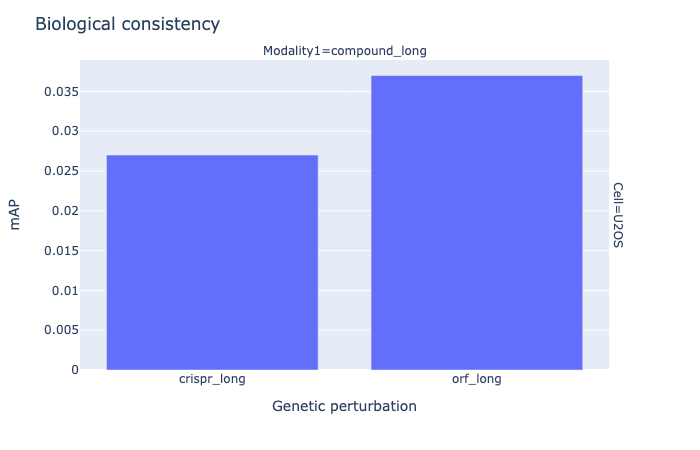

In [9]:
fig = px.bar(biological_consistency_df,
             x='Modality2',
             y='mAP',
             facet_col='Modality1',
             facet_row='Cell')
fig.update_layout(title='Biological consistency',
                  xaxis1=dict(title='Genetic perturbation'),
                  xaxis2=dict(title='Genetic perturbation'),
                  yaxis1=dict(title='mAP'),
                  yaxis3=dict(title='mAP'))
fig.show("png")
fig.write_image(f'figures/2.DeepProfiler_biological_consistency.png', width=640, height=480, scale=2)

In [10]:
replicability_df[['Modality','Cell','time','mAP']].to_csv('output/deepprofiler_replicability.csv', index=False)

biological_consistency_df[['Modality1', 'Modality2', 'Cell', 'mAP']].to_csv('output/deepprofiler_biological_consistency.csv', index=False)